<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/ViTs_GradCAM_Multi_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation

In [1]:
! pip -q install timm pandas requests
! pip -q install ml_collections
! git clone https://github.com/jeonsworld/ViT-pytorch
%cd ViT-pytorch

     |████████████████████████████████| 509 kB 2.9 MB/s 


GradCAM from scratch

In [71]:

import torch 
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def gradcam_pp(grads, activations):
    grads_power_2 = grads**2
    grads_power_3 = grads_power_2 * grads
    # Equation 19 in https://arxiv.org/abs/1710.11063
    sum_activations = torch.sum(activations, dim=[ 2, 3])
    eps = 0.000001
    aij = grads_power_2 / (2 * grads_power_2 +
                            sum_activations[:, :, None, None] * grads_power_3 + eps)
    # Now bring back the ReLU from eq.7 in the paper,
    # And zero out aijs where the activations are 0
    aij = torch.where(grads != 0, aij, 0)

    weights = torch.maximum(grads, torch.tensor(0)) * aij
    weights = torch.sum(weights, dim=[ 2, 3])
    return weights

def get_gradcam(model, img, lab=None, gradcampp=False, last_conv_layer=None):
    model.eval()
    #last_conv_layer = model.transformer.encoder.layer[11].attention_norm
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    out = model(img)
    out = torch.sigmoid(out)
    #pred_labels = torch.argwhere(out.detach().squeeze()>0.5)
    print('Probability:',[round(tl.item(), 3) for tl in out.squeeze()],'\nPredictions:', [pl.item() for pl in pred_labels.squeeze()])
    pred_onehot = F.one_hot(pred_labels, num_classes=1000)

    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    heatmap_all = []
    for pred_onehot_each in pred_onehot:
        out.backward(pred_onehot_each, retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        gradients = reshape_transform(gradients)
        activations = reshape_transform(activations)

        if gradcampp:
            pooled_gradients = gradcam_pp(gradients, activations)
        else:
            pooled_gradients = torch.mean(gradients, dim=[2, 3])
        activations *= pooled_gradients[:,:,None, None]

        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        hmap = heatmap.numpy()
        hmap[hmap<0.60] = 0
        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)

    return heatmap_all

def get_gradcam_multiclass(model, img, lab=None, gradcampp=False, last_conv_layer=None):
    model.eval()
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits, att_mat = model(img)

    #probs = torch.nn.Softmax(dim=-1)(logits)
    pred = torch.argmax(logits)
    print('Predicted Label:', pred.item())
    pred_onehot = F.one_hot(pred, num_classes=1000)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    #logits[:,pred].
    logits.backward(pred_onehot[None], retain_graph=True)
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()

    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)

    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]

    heatmap = torch.sum(activations, dim=1).squeeze().cpu()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    hmap = heatmap.numpy()
    #hmap[hmap<0.60] = 0
    heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
    heatmap1 = np.uint8(-255 * heatmap1 + 255)
    heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

    return heatmap1


ViT from Github and test on an image:

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Predicted Label: 263


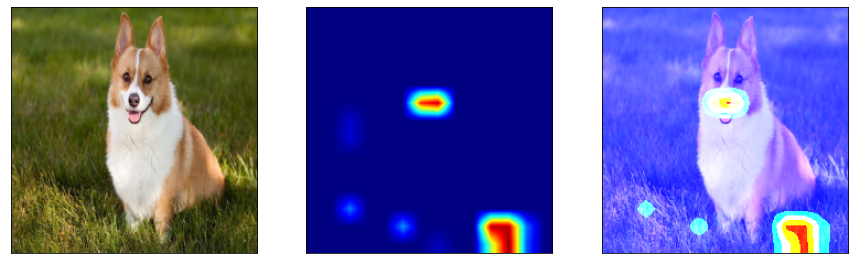

In [72]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from PIL import Image
from torchvision import transforms
from models.modeling import VisionTransformer, CONFIGS

os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))


# Test Image
#img_url = 'https://www.purina.co.uk/sites/default/files/styles/square_medium_440x440/public/2022-08/Welsh-Corgi-Pembroke.jpg'
img_url = 'https://www.animalfunfacts.net/images/stories/pets/dogs/pembroke_welsh_corgi_l.jpg'
urlretrieve(img_url, "attention_data/img.jpg")

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im = Image.open("attention_data/img.jpg")
x = transform(im)
last_conv_layer = model.transformer.encoder.layer[11].attention_norm
heatmap = get_gradcam_multiclass(model, x[None], lab=None, gradcampp=False, last_conv_layer=last_conv_layer)

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
std = torch.tensor([0.5, 0.5, 0.5])
mean = torch.tensor([0.5, 0.5, 0.5])
img = x * std[:,None, None] + mean[:,None, None]
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(heatmap)
supim = img.permute(1,2,0) + heatmap
ax[2].imshow(supim)